In [ ]:
import torch
import torch.fft
import torch.nn as nn
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [ ]:
# --- SIREN Layer using a 1x1 convolution ---
class SineLayerConvND(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        omega_0: float = np.pi * 10,
        is_first: bool = False,
        bias: bool = True,
    ):
        """
        Args:
            in_channels: Number of input channels (e.g., 2 for x,y coordinates)
            out_channels: Number of output channels
            omega_0: Frequency scaling factor (use a higher value for the first layer)
            is_first: Whether this is the first layer in the network.
        """
        super().__init__()
        # For the first layer, we use the provided omega_0; for later layers, you don't have to add an omega so we set it equal to 1
        self.omega_0 = omega_0 if is_first else 1

        # 1x1 convolution applies the same linear transform at each pixel location
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

        # Initialize weights according to SIREN paper recommendations
        with torch.no_grad():
            if is_first:
                self.conv.weight.uniform_(-1 / in_channels, 1 / in_channels)
            else:
                # If you want to allow different omega_0 for hidden layers, divide the bound by omega_0.
                bound = np.sqrt(6 / in_channels) / self.omega_0
                self.conv.weight.uniform_(-bound, bound)
            if self.conv.bias is not None:
                self.conv.bias.fill_(0)

    def forward(self, x):
        return torch.sin(self.omega_0 * self.conv(x))


In [ ]:
# --- Complete SIREN Network ---
class SirenConvNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        num_hidden_layers: int,
        first_omega_0: float = np.pi * 10,
    ):
        """
        A SIREN network built with pointwise (1x1) convolutions.

        Args:
            in_channels: Number of input channels (for coordinates, usually 2 for a (x,y) grid)
            hidden_channels: Number of channels in hidden layers
            out_channels: Number of output channels (e.g., 3 for an RGB image)
            num_hidden_layers: Number of hidden Sine layers
            first_omega_0: The omega_0 for the first layer.
        """
        super().__init__()
        layers: list[nn.Module] = []
        # First layer with a higher omega_0
        layers.append(
            SineLayerConvND(
                in_channels, hidden_channels, omega_0=first_omega_0, is_first=True
            )
        )

        # Hidden layers
        for _ in range(num_hidden_layers):
            layers.append(
                SineLayerConvND(
                    hidden_channels, hidden_channels, omega_0=1, is_first=False
                )
            )

        # Final layer: use a plain 1x1 conv without sine activation.
        final_layer = nn.Conv2d(hidden_channels, out_channels, kernel_size=1, bias=True)
        layers.append(final_layer)
        # layers.append(nn.Tanh())  # make sure the data is in the range [-1,1]
        self.net = nn.Sequential(*layers)

        # Since the pixel range is from -1 to 1, data_range should be 2.0, or the tuple (-1,1).
        self.ssim_metric = StructuralSimilarityIndexMeasure(data_range=(-1.0, 1.0))

    def loss(self, pred: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Computes the combined loss as the sum of MSE loss and (1 - SSIM).

        Args:
            pred (torch.Tensor): The predicted image tensor.
            x (torch.Tensor): The ground truth image tensor.

        Returns:
            torch.Tensor: A scalar tensor representing the combined loss.
        """
        # Compute MSE loss
        mse_loss = F.mse_loss(pred, x)
        # Compute SSIM value, which lies between 0 and 1; lower SSIM is worse, so we use (1 - SSIM) as the loss component. We need to ensure the range of the prediction is on [-1,1] so we clamp the tensor
        pred_clamped = torch.clamp(pred, -1, 1)
        ssim_loss = 1 - self.ssim_metric(pred_clamped, x)

        return mse_loss + ssim_loss

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


In [79]:
# --- Helper function to create a coordinate grid ---
def get_coordinate_grid(
    height: int, width: int, device: torch.device = torch.device("cpu")
):
    """
    Generates a coordinate grid of shape (1, 2, H, W) with values in [-1, 1].

    The two channels correspond to the x and y coordinates respectively.
    """
    y = torch.linspace(-1, 1, height, device=device)
    x = torch.linspace(-1, 1, width, device=device)
    # Use indexing='ij' to get grid_y of shape (H, W) and grid_x of shape (H, W)
    grid_y, grid_x = torch.meshgrid(y, x, indexing="ij")
    # Stack so that the grid has 2 channels: (x, y)
    grid = torch.stack((grid_x, grid_y), dim=0)  # shape: (2, H, W)
    return grid.unsqueeze(0)  # add batch dimension -> (1, 2, H, W)


Epoch 100/2000, Loss: 0.442936
Epoch 200/2000, Loss: 0.225848
Epoch 300/2000, Loss: 0.168339
Epoch 400/2000, Loss: 0.135154
Epoch 500/2000, Loss: 0.114608
Epoch 600/2000, Loss: 0.100867
Epoch 700/2000, Loss: 0.090868
Epoch 800/2000, Loss: 0.082712
Epoch 900/2000, Loss: 0.074875
Epoch 1000/2000, Loss: 0.068862
Epoch 1100/2000, Loss: 0.063901
Epoch 1200/2000, Loss: 0.059824
Epoch 1300/2000, Loss: 0.055825
Epoch 1400/2000, Loss: 0.052666
Epoch 1500/2000, Loss: 0.049990
Epoch 1600/2000, Loss: 0.046937
Epoch 1700/2000, Loss: 0.044787
Epoch 1800/2000, Loss: 0.042440
Epoch 1900/2000, Loss: 0.040359
Epoch 2000/2000, Loss: 0.038437


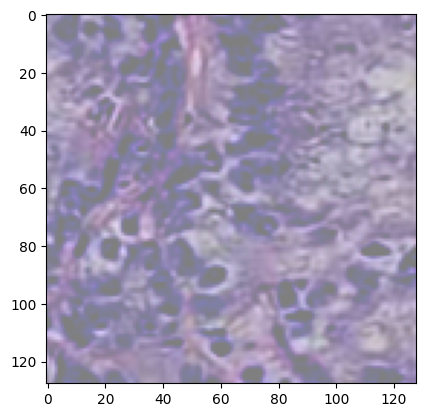

In [80]:
# --- Example training loop ---
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Normalize image values to [-1, 1].
target_image = (
    torch.tensor(
        np.array(
            Image.open("../test_VAE_Equivariant/epochs/example_imgs/img_0.png"),
            dtype=np.float32,
        ),
        device=device,
        dtype=torch.float32,
    )
    .permute(2, 0, 1)
    .unsqueeze(0)
)
target_image /= 255
target_image -= 0.5
target_image *= 2

# Create the normalized coordinate grid.
_, C, H, W = target_image.shape  # For example, an RGB image of size 128x128
coord_grid = get_coordinate_grid(H, W, device=device)  # shape: (1, 2, H, W)

# Create the network.
model = SirenConvNet(
    in_channels=2,
    hidden_channels=256,
    out_channels=C,
    num_hidden_layers=4,
    first_omega_0=np.pi*10,
)
model.to(device=device)
model.compile(fullgraph=True)
# Define optimizer and loss.
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

num_epochs = 2000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    # Forward pass: predict the image from coordinates.
    pred = model(coord_grid)  # shape: (1, C, H, W)

    # Compute loss
    loss = model.loss(pred, target_image)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.6f}")

# After training, you can visualize or save the output.
# For example:
pred_show = torch.clamp(pred.detach().cpu().squeeze().permute(1, 2, 0),0,1).numpy()
pred_show /= 2
pred_show += 0.5
plt.imshow(pred_show)
plt.show()


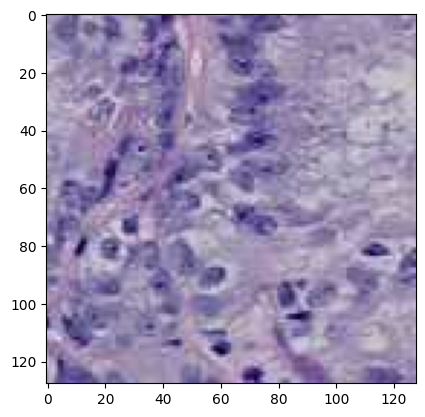

In [81]:
target_image_show = target_image.detach().cpu().squeeze().permute(1, 2, 0).numpy()
target_image_show /= 2
target_image_show += 0.5
plt.imshow(target_image_show)
plt.show()

0.072795